In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()


# reflect the tables
Base.prepare(autoload_with=engine)

In [7]:
# View all of the classes that automap found

Base.classes.keys()

['station', 'measurement']

In [8]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)


In [10]:
# Maddie's Notes - Testing the data below:
for row in session.query(Measurement.station, Measurement.date).limit(5).all():
    print(row)

('USC00519397', '2010-01-01')
('USC00519397', '2010-01-02')
('USC00519397', '2010-01-03')
('USC00519397', '2010-01-04')
('USC00519397', '2010-01-06')


In [11]:
# Maddie's Notes - Inspecting the data below:

inspector = inspect(engine)

print("Table: Measurement")
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column["name"], column["type"])

print("----------------------")

print("Table: Station")
columns = inspector.get_columns('Station')
for column in columns:
    print(column["name"], column["type"])


Table: Measurement
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
----------------------
Table: Station
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

In [13]:
#Testing date formats
print(dt.datetime(2017,8,23))

2017-08-23 00:00:00


2016-08-23 00:00:00
      precipitation        date
0              0.08  2016-08-24
1006            NaN  2016-08-24
1524           2.15  2016-08-24
702            2.28  2016-08-24
360            2.15  2016-08-24
...             ...         ...
1522           0.00  2017-08-22
1523           0.08  2017-08-23
359            0.00  2017-08-23
1005           0.00  2017-08-23
2222           0.45  2017-08-23

[2223 rows x 2 columns]


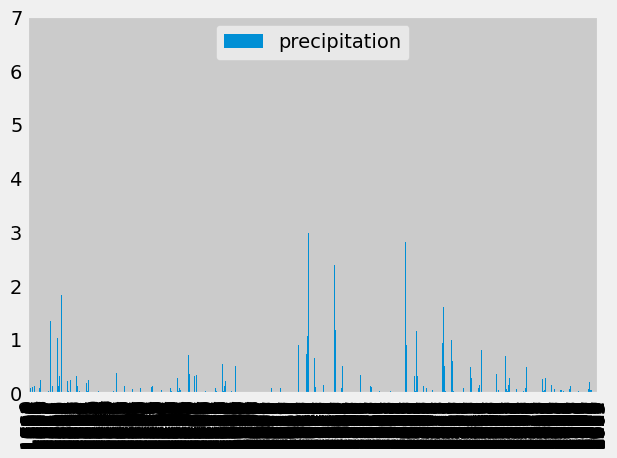

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

latest_date = dt.datetime(2017,8,23)

# Calculate the date one year from the last date in data set.
one_year_before = year_ago = latest_date - dt.timedelta(days=365)

print(one_year_before)

# Perform a query to retrieve the data and precipitation scores

session.query(Measurement.prcp, Measurement.date).\
    filter(Measurement.date >=one_year_before, Measurement.date <=latest_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precip_data = session.query(Measurement.prcp, Measurement.date).\
    filter(Measurement.date >=one_year_before, Measurement.date <=latest_date).all()

df_precip = pd.DataFrame(precip_data)

df_precip.rename(columns={'prcp': 'precipitation'}, inplace=True)

# Sort the dataframe by date
df_precip_sorted = df_precip.sort_values(by='date')

print(df_precip_sorted)

# Use Pandas Plotting with Matplotlib to plot the data

df = pd.DataFrame(df_precip_sorted)
df.plot.bar()
plt.tight_layout()
plt.show()


In [15]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = df_precip_sorted.describe()
print(summary_statistics)

       precipitation
count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000


# Exploratory Station Analysis

In [16]:
# Maddie's Notes - Inspecting the data below:

inspector = inspect(engine)

print("Table: Measurement")
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column["name"], column["type"])

print("----------------------")

print("Table: Station")
columns = inspector.get_columns('Station')
for column in columns:
    print(column["name"], column["type"])

Table: Measurement
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
----------------------
Table: Station
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [40]:
# Design a query to calculate the total number of stations in the dataset
unique_count = session.query(func.count(Measurement.station.distinct())).scalar()
print(unique_count)

9


In [44]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
total_count = session.query(
    Measurement.station,
    func.count().label('row_count')
).group_by(Measurement.station).all()

total_count_df = pd.DataFrame(total_count)



total_count_df_sorted = total_count_df.sort_values(by='row_count')

print(total_count_df_sorted)

       station  row_count
5  USC00518838        511
4  USC00517948       1372
0  USC00511918       1979
2  USC00514830       2202
3  USC00516128       2612
8  USC00519523       2669
1  USC00513117       2709
7  USC00519397       2724
6  USC00519281       2772


In [47]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
lowest_value = session.query(func.min(Measurement.tobs)).filter(Measurement.station == 'USC00519281').scalar()
highest_value = session.query(func.max(Measurement.tobs)).filter(Measurement.station == 'USC00519281').scalar()
average_value = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').scalar()
print(lowest_value)
print(highest_value)
print(average_value)


54.0
85.0
71.66378066378067


     tobs
0    77.0
1    80.0
2    80.0
3    75.0
4    73.0
..    ...
346  77.0
347  77.0
348  76.0
349  76.0
350  79.0

[351 rows x 1 columns]


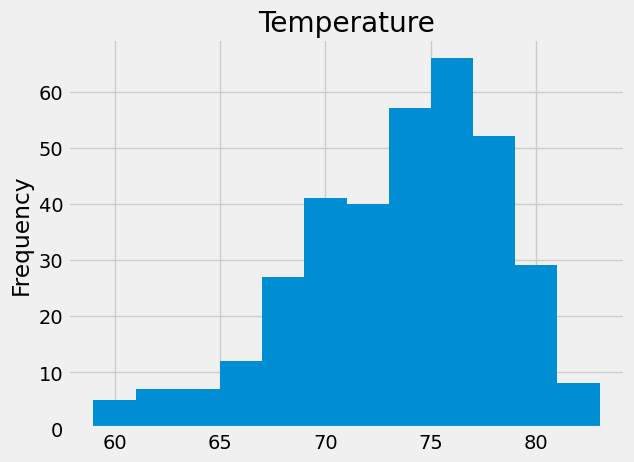

In [54]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_data = session.query(Measurement.tobs, Measurement.date, Measurement.station).\
    filter(Measurement.date >=one_year_before, Measurement.date <=latest_date, Measurement.station == 'USC00519281').all()

df_temp = pd.DataFrame(temp_data)

df_temp_final = df_temp.drop(columns=['date','station'])

print(df_temp_final)

plt.hist(df_temp_final, bins=12)
plt.ylabel('Frequency')
plt.title('Temperature')
plt.show()

# Close Session

In [55]:
# Close Session
session.close()